In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import seaborn as sns

In [63]:
df = pd.read_csv("../midterm_prep/CPS1988.csv")
df.head()

,wage,education,experience,ethnicity,smsa,region,parttime
0,354.94,7,45,cauc,yes,northeast,no
1,123.46,12,1,cauc,yes,northeast,yes
2,370.37,9,9,cauc,yes,northeast,no
3,754.94,11,46,cauc,yes,northeast,no
4,593.54,12,36,cauc,yes,northeast,no


In [64]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28155 entries, 0 to 28154
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   wage        28155 non-null  float64
 1   education   28155 non-null  int64  
 2   experience  28155 non-null  int64  
 3   ethnicity   28155 non-null  object 
 4   smsa        28155 non-null  object 
 5   region      28155 non-null  object 
 6   parttime    28155 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 1.5+ MB
None


In [65]:
print(df.describe())

               wage     education    experience
count  28155.000000  28155.000000  28155.000000
mean     603.726846     13.067874     18.199929
std      453.547350      2.899682     13.079233
min       50.050000      0.000000     -4.000000
25%      308.640000     12.000000      8.000000
50%      522.320000     12.000000     16.000000
75%      783.480000     15.000000     27.000000
max    18777.200000     18.000000     63.000000


In [66]:
missing_values = df.isnull().sum()
missing_values

wage          0
education     0
experience    0
ethnicity     0
smsa          0
region        0
parttime      0
dtype: int64

In [67]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.0 MB/s eta 0:00:00a 0:00:01


In [68]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [69]:
target_column = "parttime"
features = df.drop(columns=[target_column])
target = df[target_column]

In [70]:
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

In [72]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_columns = features.select_dtypes(include=['int64', 'float64']).columns
features[numerical_columns] = scaler.fit_transform(features[numerical_columns])

In [73]:
features = pd.get_dummies(features, drop_first=True)

In [74]:
features

,wage,education,experience,ethnicity_cauc,smsa_yes,region_northeast,region_south,region_west
0,-0.548545,-2.092637,2.049092,True,True,True,False,False
1,-1.058931,-0.368279,-1.315080,True,True,True,False,False
2,-0.514524,-1.402894,-0.703412,True,True,True,False,False
3,0.333407,-0.713151,2.125550,True,True,True,False,False
4,-0.022461,-0.368279,1.360966,True,True,True,False,False
...,...,...,...,...,...,...,...,...
28150,-0.545921,-0.368279,-0.397578,True,False,False,False,True
28151,-0.650631,-0.368279,-0.779871,True,False,False,False,True
28152,-0.388890,-0.368279,0.749298,True,False,False,False,True
28153,0.507769,1.356078,0.902215,True,False,False,False,True


In [75]:
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

In [76]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

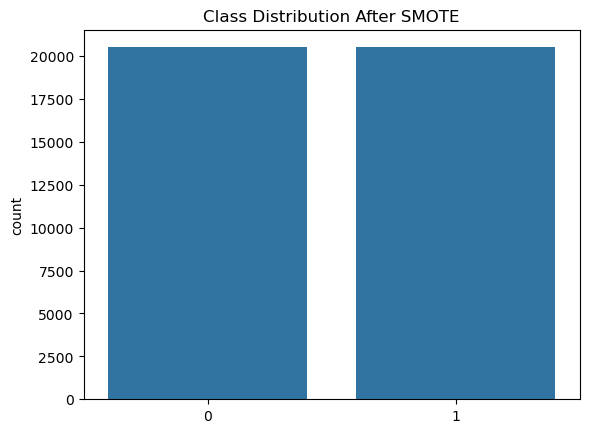

In [78]:
sns.countplot(x=y_train_smote)
plt.title("Class Distribution After SMOTE")
plt.show()

In [79]:
def train_random_forest():
    rf = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    grid_search = GridSearchCV(rf, param_grid, scoring='balanced_accuracy', cv=3)
    grid_search.fit(X_train_smote, y_train_smote)
    return grid_search.best_estimator_

In [80]:
def train_xgboost():
    xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6]
    }
    grid_search = GridSearchCV(xgb, param_grid, scoring='balanced_accuracy', cv=3)
    grid_search.fit(X_train_smote, y_train_smote)
    return grid_search.best_estimator_

In [81]:
rf_model = train_random_forest()
xgb_model = train_xgboost()

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:20:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:20:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:20:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:20:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

In [82]:
rf_val_predictions = rf_model.predict(X_val)
xgb_val_predictions = xgb_model.predict(X_val)

In [83]:
rf_val_score = balanced_accuracy_score(y_val, rf_val_predictions)
xgb_val_score = balanced_accuracy_score(y_val, xgb_val_predictions)

In [84]:
print("Random Forest Balanced Accuracy:", rf_val_score)
print("XGBoost Balanced Accuracy:", xgb_val_score)

Random Forest Balanced Accuracy: 0.782515515242447
XGBoost Balanced Accuracy: 0.8118870626747596


In [85]:
best_model = rf_model if rf_val_score > xgb_val_score else xgb_model

In [86]:
# Predicting on Test Dataset goes here...